In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from keras import models
from keras.models import Sequential
from keras.optimizers import Adam
import tensorflow as tf
import os
import copy
from sklearn.model_selection import train_test_split

In [9]:
# Run Noise_process before run this file
def get_dataset(obj_name):
    filename_labels = 'train_labels.npy'
    filename_origin = 'origin_cifar10.npy'
    filename_small_noise = 'small_noise_cifar10.npy'
    filename_medium_noise = 'medium_noise_cifar10.npy'
    filename_large_noise = 'large_noise_cifar10.npy'
    
    train_set = None
    match obj_name:
        case 'origin':
            train_set = np.load(filename_origin)
        case 'small_noise':
            train_set = np.load(filename_small_noise)
        case 'medium_noise':
            train_set = np.load(filename_medium_noise)
        case 'large_noise':
            train_set = np.load(filename_large_noise)
        case _:
            raise ValueError(f"Unknown obj_name: {obj_name}")
    label_set = np.load(filename_labels) if train_set.size > 0 else None

    if label_set is None or train_set is None:
        print("Run Noise_process.ipynb before run this file")
    return train_set, label_set

In [10]:
ORIGIN='origin'
SMALL='small_noise'
MEDIUM='medium_noise'
LARGE='large_noise'
all_dataset = [ORIGIN, SMALL, MEDIUM, LARGE]

In [11]:
# CNN: learning_rate, num_filter, filter_size
best_config_origin_cnn={'name': ORIGIN, 'num_filter': 128}
best_config_small_cnn={'name': SMALL, 'num_filter': 64}
best_config_medium_cnn={'name': MEDIUM, 'num_filter': 128}
best_config_large_cnn={'name': LARGE, 'num_filter': 128}
best_config_cnn=[]
best_config_cnn.append(best_config_origin_cnn)
best_config_cnn.append(best_config_small_cnn)
best_config_cnn.append(best_config_medium_cnn)
best_config_cnn.append(best_config_large_cnn)

Build Model

In [12]:
def build_simple_cnn(num_filter, learning_rate=0.0005, filter_size=(3,3), input_shape=(32, 32, 3), num_classes=10):
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))  
    model.add(layers.Conv2D(num_filter, filter_size, activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [13]:
def get_processed_dataset(model_name):
    train_set, label_set = get_dataset(model_name)

    X_combined_reshaped = train_set.reshape(-1, 32, 32, 3)
    X_combined_reshaped = X_combined_reshaped.astype('float32') / 255.0
    y_combined_categorical = to_categorical(label_set, num_classes=10)

    return X_combined_reshaped, y_combined_categorical

In [17]:
def plot_learning_curves(all_history, model_name):
    train_loss = np.mean([h['loss'] for h in all_history], axis=0)
    val_loss = np.mean([h['val_loss'] for h in all_history], axis=0)
    train_accuracy = np.mean([h['accuracy'] for h in all_history], axis=0)
    val_accuracy = np.mean([h['val_accuracy'] for h in all_history], axis=0)

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title(f'Loss Curve {model_name} CNN')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy, label='Train Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title(f'Accuracy Curve {model_name} CNN')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()

Fold 1/20
Fold 2/20
Fold 3/20
Fold 4/20
Fold 5/20
Fold 6/20
Fold 7/20
Fold 8/20
Fold 9/20
Fold 10/20
Fold 11/20
Fold 12/20
Fold 13/20
Fold 14/20
Fold 15/20
Fold 16/20
Fold 17/20
Fold 18/20
Fold 19/20
Fold 20/20


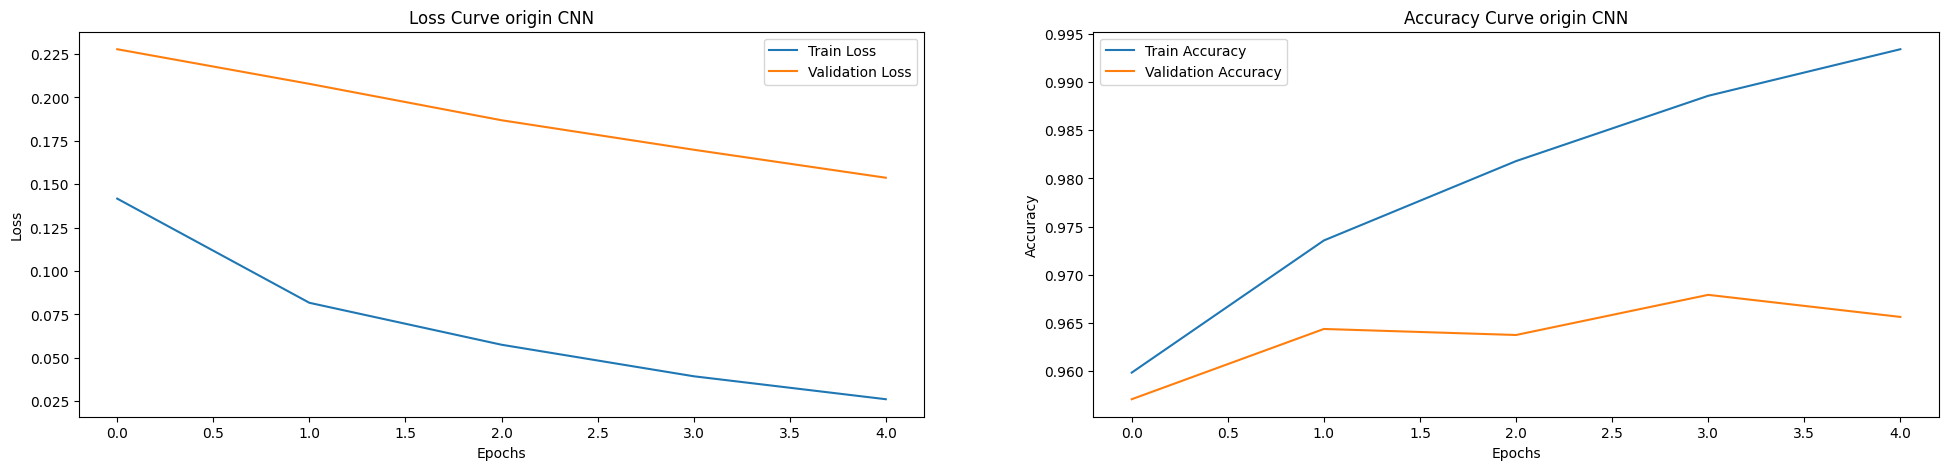

38/38 [==============================] - 0s 11ms/step
Run origin, in small_noise: Accuracy: 0.5275, Precision: 0.551625347461478, Recall: 0.5275
38/38 [==============================] - 0s 10ms/step
Run origin, in medium_noise: Accuracy: 0.485, Precision: 0.4846993324674645, Recall: 0.485
38/38 [==============================] - 0s 10ms/step
Run origin, in large_noise: Accuracy: 0.25, Precision: 0.46826740879308604, Recall: 0.25
Fold 1/20
Fold 2/20
Fold 3/20
Fold 4/20
Fold 5/20
Fold 6/20
Fold 7/20
Fold 8/20
Fold 9/20
Fold 10/20
Fold 11/20
Fold 12/20
Fold 13/20
Fold 14/20
Fold 15/20
Fold 16/20
Fold 17/20
Fold 18/20
Fold 19/20
Fold 20/20


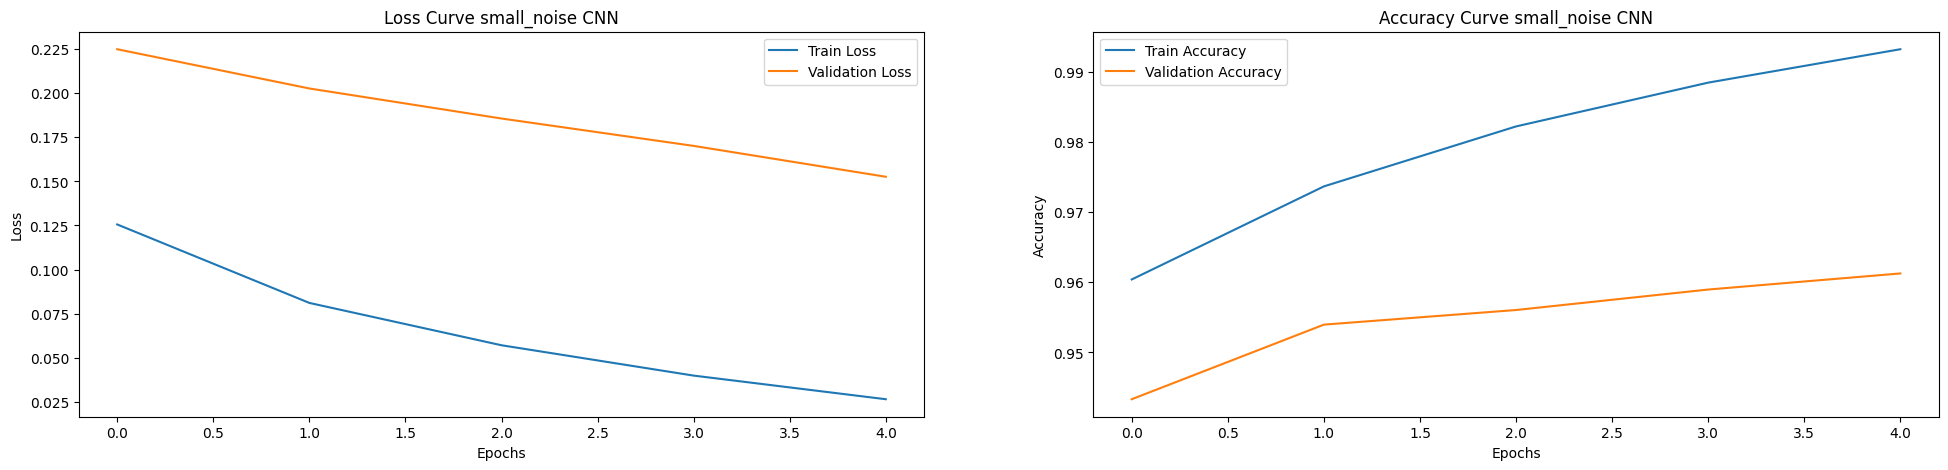

38/38 [==============================] - 0s 8ms/step
Run small_noise, in origin: Accuracy: 0.5375, Precision: 0.5353286914999426, Recall: 0.5375
38/38 [==============================] - 0s 6ms/step
Run small_noise, in medium_noise: Accuracy: 0.47, Precision: 0.4676156268431271, Recall: 0.47
38/38 [==============================] - 0s 6ms/step
Run small_noise, in large_noise: Accuracy: 0.27, Precision: 0.45495756821447675, Recall: 0.27
Fold 1/20
Fold 2/20
Fold 3/20
Fold 4/20
Fold 5/20
Fold 6/20
Fold 7/20
Fold 8/20
Fold 9/20
Fold 10/20
Fold 11/20
Fold 12/20
Fold 13/20
Fold 14/20
Fold 15/20
Fold 16/20
Fold 17/20
Fold 18/20
Fold 19/20
Fold 20/20


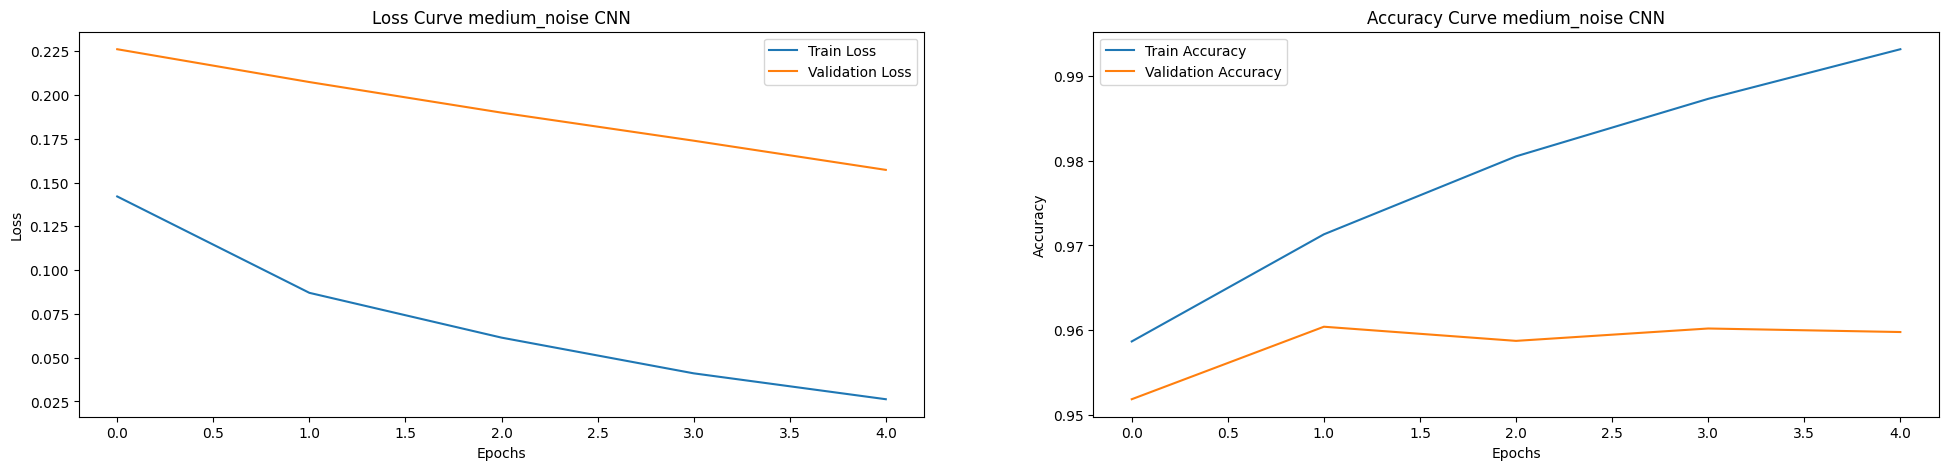

38/38 [==============================] - 0s 11ms/step
Run medium_noise, in origin: Accuracy: 0.5358333333333334, Precision: 0.5337487525717485, Recall: 0.5358333333333334
38/38 [==============================] - 0s 11ms/step
Run medium_noise, in small_noise: Accuracy: 0.525, Precision: 0.54223318398436, Recall: 0.525
38/38 [==============================] - 0s 11ms/step
Run medium_noise, in large_noise: Accuracy: 0.25083333333333335, Precision: 0.37976598237357206, Recall: 0.25083333333333335
Fold 1/20
Fold 2/20
Fold 3/20
Fold 4/20
Fold 5/20
Fold 6/20
Fold 7/20
Fold 8/20
Fold 9/20
Fold 10/20
Fold 11/20
Fold 12/20
Fold 13/20
Fold 14/20
Fold 15/20
Fold 16/20
Fold 17/20
Fold 18/20
Fold 19/20
Fold 20/20


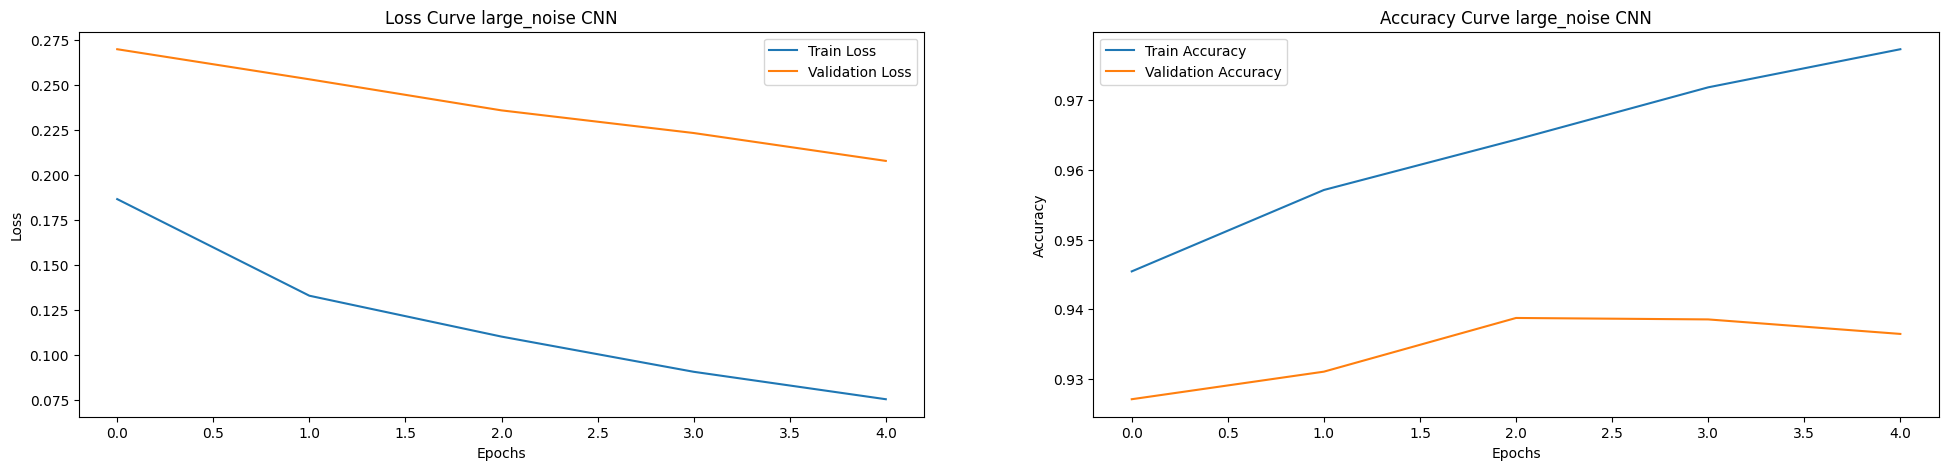

38/38 [==============================] - 0s 10ms/step
Run large_noise, in origin: Accuracy: 0.39, Precision: 0.44159826778177186, Recall: 0.39
38/38 [==============================] - 0s 10ms/step
Run large_noise, in small_noise: Accuracy: 0.4216666666666667, Precision: 0.4485578668461388, Recall: 0.4216666666666667
38/38 [==============================] - 0s 11ms/step
Run large_noise, in medium_noise: Accuracy: 0.355, Precision: 0.4022837258000622, Recall: 0.355


In [19]:
all_performance_cnn = {}
all_histories = {}
for config in best_config_cnn:
    model_name = config['name']

    model_performance = {}
    
    # Use 80% for cross validation and 20% for robustness test for other model
    x_processed, y_processed = get_processed_dataset(model_name)
    x_cv, _, y_cv, _ = train_test_split(x_processed, y_processed, test_size=0.2, random_state=42)

    # Cross Validation
    kf = KFold(n_splits=20, shuffle=True, random_state=42)
    all_history = []

    for fold, (train_index, val_index) in enumerate(kf.split(x_cv)):
        print(f'Fold {fold + 1}/{20}')

        model = build_simple_cnn(config['num_filter'])

        x_train, x_val = x_cv[train_index], x_cv[val_index]
        y_train, y_val = y_cv[train_index], y_cv[val_index]

        history = model.fit(x_train, y_train, epochs=5, batch_size=128, validation_data=(x_val, y_val), verbose=0)
        all_history.append(history.history)
        model_performance_fold = {}
        # Robustness Test
        for dataset_name in all_dataset:
            if dataset_name == model_name:
                # Do robustness evaluations on other dataset
                continue
            # Get rest part of dataset which never used on Cross Validation
            x_evaluated, y_evaluated = get_processed_dataset(dataset_name)
            _, x_test, _, y_test = train_test_split(x_evaluated, y_evaluated, test_size=0.2, random_state=42)

            y_pred = model.predict(x_test)
            y_pred_classes = np.argmax(y_pred, axis=1)
            y_true_classes = np.argmax(y_test, axis=1) 

            accuracy = accuracy_score(y_true_classes, y_pred_classes)
            precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
            recall = recall_score(y_true_classes, y_pred_classes, average='weighted')

            print(f"Run {model_name}, in {dataset_name} at Fold {fold + 1}/{20}: Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}")
            print(f"y_pred: {y_pred}, y_pred_classes: {y_pred_classes}, y_test: {y_test}, y_true_classes: {y_true_classes}")
            
            model_performance_fold[dataset_name] = {'accuracy' : accuracy, 'precision' : precision, 'recall' : recall}
        model_performance[fold+1] = model_performance_fold

    all_performance_cnn[model_name] = model_performance

    plot_learning_curves(all_history, model_name)
    all_histories[model_name] = all_history

    
    





In [20]:
all_performance_cnn

{'origin': {'small_noise': {'accuracy': 0.5275,
   'precision': 0.551625347461478,
   'recall': 0.5275},
  'medium_noise': {'accuracy': 0.485,
   'precision': 0.4846993324674645,
   'recall': 0.485},
  'large_noise': {'accuracy': 0.25,
   'precision': 0.46826740879308604,
   'recall': 0.25}},
 'small_noise': {'origin': {'accuracy': 0.5375,
   'precision': 0.5353286914999426,
   'recall': 0.5375},
  'medium_noise': {'accuracy': 0.47,
   'precision': 0.4676156268431271,
   'recall': 0.47},
  'large_noise': {'accuracy': 0.27,
   'precision': 0.45495756821447675,
   'recall': 0.27}},
 'medium_noise': {'origin': {'accuracy': 0.5358333333333334,
   'precision': 0.5337487525717485,
   'recall': 0.5358333333333334},
  'small_noise': {'accuracy': 0.525,
   'precision': 0.54223318398436,
   'recall': 0.525},
  'large_noise': {'accuracy': 0.25083333333333335,
   'precision': 0.37976598237357206,
   'recall': 0.25083333333333335}},
 'large_noise': {'origin': {'accuracy': 0.39,
   'precision': 0.44

In [21]:
all_histories

{'origin': [{'loss': [2.388148069381714,
    1.3745982646942139,
    0.9905568957328796,
    0.696032702922821,
    0.4631194472312927],
   'accuracy': [0.3120613992214203,
    0.5177631378173828,
    0.6574561595916748,
    0.7787280678749084,
    0.8695175647735596],
   'val_loss': [2.216460704803467,
    2.1619861125946045,
    2.0634772777557373,
    2.0054707527160645,
    1.9065463542938232],
   'val_accuracy': [0.375,
    0.5,
    0.4749999940395355,
    0.5208333134651184,
    0.5083333253860474]},
  {'loss': [0.3644128441810608,
    0.2121787965297699,
    0.1299585998058319,
    0.0681350976228714,
    0.04017913341522217],
   'accuracy': [0.8960526585578918,
    0.9546052813529968,
    0.9787280559539795,
    0.9927631616592407,
    0.9986842274665833],
   'val_loss': [1.6250170469284058,
    1.4568039178848267,
    1.288801670074463,
    1.1102169752120972,
    0.9594035744667053],
   'val_accuracy': [0.7791666388511658,
    0.7916666865348816,
    0.8083333373069763,
    0